<p style="font-family:'Tw Cen MT';font-size:14px"> P100 - Forecasting and Prediction - Course Project</p>

# Predict Churn for a Gym Chain
<p style="font-family:'Tw Cen MT';font-size:16px">by Isaac Nahmias, March 2022</p>


---
## Introduction
### Abstract
One of the most common problems gyms and other services face is customer churn. The gym chain *Model Fitness* is developing a customer interaction strategy based on analytical data in order to fight churn.

*Model Fitness* provided me with CSV files containing data on churn for a given month and information on the month preceding it. In this paper I will analyze the data provided to select churn indicators, with it I will create a forecasting model so the gym will be able to predict the probability of churn for each customer.

### Uploading the data files and relevant liberies:

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="darkgrid")

In [2]:
try:
    df = pd.read_csv('/datasets/gym_churn_us.csv')
except:
    df = pd.read_csv('gym_churn_us.csv')

df.columns = df.columns.str.lower()

In [3]:
#first five enetries:
df.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


### Data Description
The dataset includes the following fields:
* `churn` — the fact of churn for the month in question.

User data for the preceding month:
* `gender`
* `near_location` — whether the user lives or works in the neighborhood where the gym is located
* `partner` — whether the user is an employee of a <span title="The gym has partner companies whose employees get discounts"><u>partner company</u></span> (hover for more information)
* `promo_friends` — whether the user originally signed up through a "bring a friend" offer 
* `phone` — whether the user provided their phone number
* `age`
* `lifetime` — the time (in months) since the customer first came to the gym

Data from the log of visits and purchases and data on current membership status:
* `contract_period` — 1 month, 3 months, 6 months, or 1 year
* `month_to_end_contract` — the months remaining until the contract expires
* `group_visits` — whether the user takes part in group sessions
* `avg_class_frequency_total` — average frequency of visits per week over the customer's lifetime
* `avg_class_frequency_current_month` — average frequency of visits per week over the preceding month
* `avg_additional_charges_total` — the total amount of money spent on other gym services: cafe, athletic goods, cosmetics, massages, etc.

### Initial Data Preprocessing

In [4]:
print('Columns count:\t',df.shape[1])
print('Rows count:\t',df.shape[0])

Columns count:	 14
Rows count:	 4000


In [5]:
print("Null Values:\t\t",df.isnull().sum().sum())
print("Duplicated Enteries:\t",df.duplicated().sum())

Null Values:		 0
Duplicated Enteries:	 0


The dataframe contains 14 columns and 4000 records. There are no missing entries at all and there is no record that appears more than once.

Now all I have left to do is to make sure that every column contains the righ type of data:

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

In [7]:
for col in df.select_dtypes(include='float').columns:
    df[col] = pd.to_numeric(df[col], downcast='float')
    
for col in df.select_dtypes(include='int').columns:
    df[col] = pd.to_numeric(df[col], downcast='integer')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int8   
 1   near_location                      4000 non-null   int8   
 2   partner                            4000 non-null   int8   
 3   promo_friends                      4000 non-null   int8   
 4   phone                              4000 non-null   int8   
 5   contract_period                    4000 non-null   int8   
 6   group_visits                       4000 non-null   int8   
 7   age                                4000 non-null   int8   
 8   avg_additional_charges_total       4000 non-null   float32
 9   month_to_end_contract              4000 non-null   float32
 10  lifetime                           4000 non-null   int8   
 11  avg_class_frequency_total          4000 non-null   float

---
## Exploratory Data Analysis

### The story told by the averages

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943649,96.355606,0.148205,68.868832,136.220161,210.949619,552.590759
month_to_end_contract,4000.0,4.322750,4.191243,1.000000,1.000000,1.000000,6.000000,12.000000


* Because the client's gender identity is presented in a binary way, it is not possible to know whether the client is a man or a woman, but since the average is about 0.5 it can be determined that gender-wise, the gym's clients are divided quite identically.
* The binary averages tell us further that most of the gym's clients:
    1. live or work near it
    1. left a phone number in the registration
    1. did not come through a "bring a friend" promotion
    1. do not attend to group classes
    1. and most importantly: almost 27% of them have left the gym on the current month.
* The average age of the gym's clients is 29, with a standard deviation of only about three years.
* Most of the clients prefer contract period of 1 month.
* The average lifetime of the costumers is almost four months, and this is when there is at least one costumer with lifetime of two years and an half.
* On average a costumer spends about 147 USD on additional charges.
* The average frequency of visits is about 1.9 times a week, some come everyday and some didn't show up even once, by now.

While all of this helps me understand what characterizes all clients in general, my goal is to find the factors that influence churn. So, in the next step, I will check each of the averages again, but this time with a separation between remaining customers ($Churn=0$) and customers who have left ($Churn=1$).

### What factors impact churn most?

Next I will ask Python to show me for each feature a statistical description, one for those who stayed and one for those who left, followed by a histogram of the feature with different colors for churn:

In [10]:
feature_desc = df.groupby('churn').describe(include="all")

In [11]:
bin_col = []
mul_col = []
for col in df.columns:
    if df[col].nunique() == 2:
        bin_col.append(col)
    else:
        mul_col.append(col)

> Gender:


,count,mean,std,min,25%,50%,75%,max
churn,,,,,,,,
0,2939.0,0.510037,0.499984,0.0,0.0,1.0,1.0,1.0
1,1061.0,0.510839,0.500118,0.0,0.0,1.0,1.0,1.0


,0,1
gender,1,0
churn rate,26.6%,26.5%


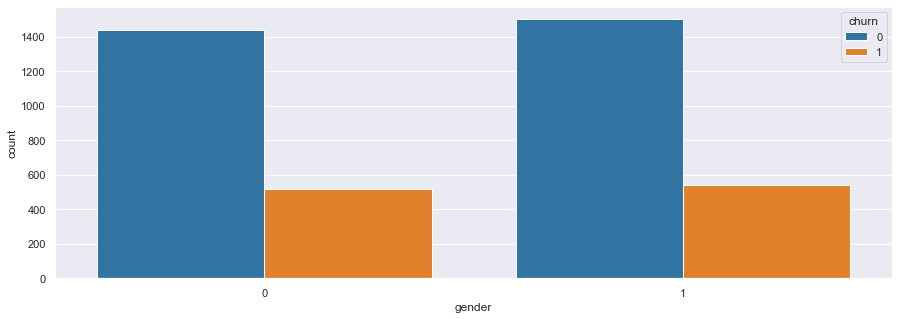

> Near_location:


,count,mean,std,min,25%,50%,75%,max
churn,,,,,,,,
0,2939.0,0.873086,0.332933,0.0,1.0,1.0,1.0,1.0
1,1061.0,0.768143,0.422217,0.0,1.0,1.0,1.0,1.0


,0,1
near_location,0,1
churn rate,39.7%,24.1%


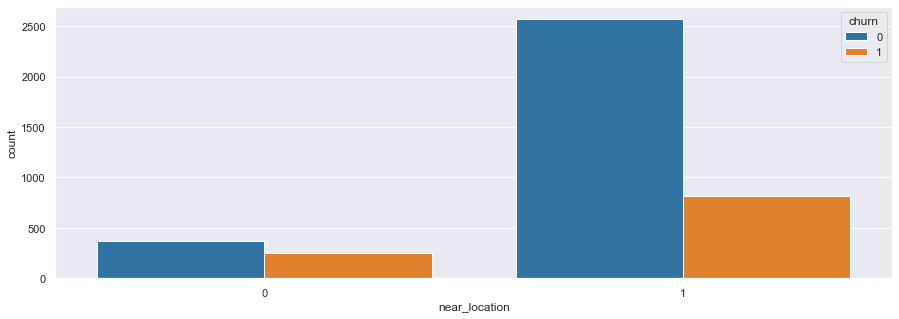

> Partner:


,count,mean,std,min,25%,50%,75%,max
churn,,,,,,,,
0,2939.0,0.534195,0.498914,0.0,0.0,1.0,1.0,1.0
1,1061.0,0.355325,0.478837,0.0,0.0,0.0,1.0,1.0


,0,1
partner,0,1
churn rate,33.3%,19.4%


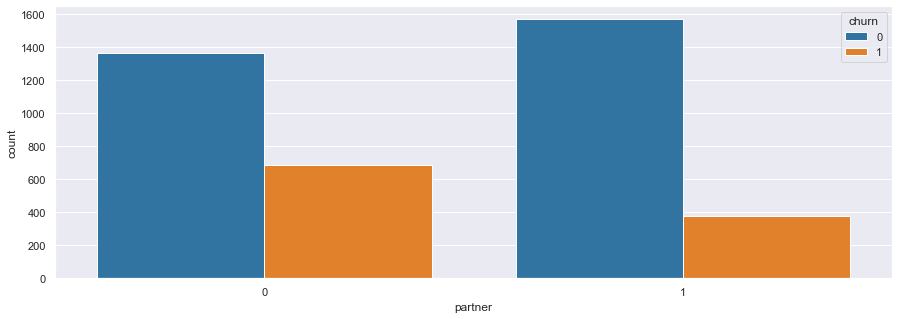

> Promo_friends:


,count,mean,std,min,25%,50%,75%,max
churn,,,,,,,,
0,2939.0,0.353522,0.478144,0.0,0.0,0.0,1.0,1.0
1,1061.0,0.183789,0.387495,0.0,0.0,0.0,0.0,1.0


,0,1
promo_friends,0,1
churn rate,31.3%,15.8%


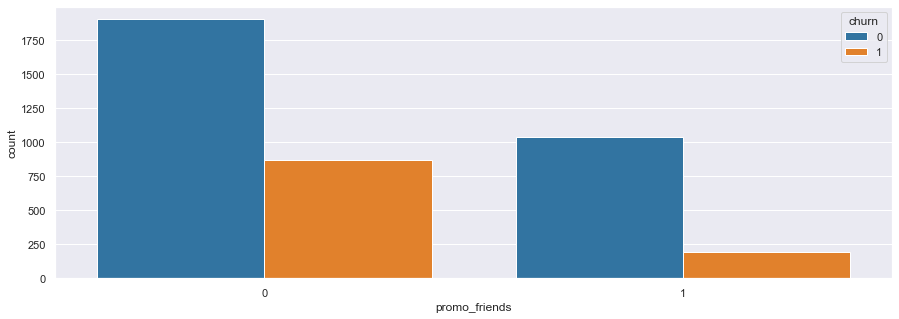

> Phone:


,count,mean,std,min,25%,50%,75%,max
churn,,,,,,,,
0,2939.0,0.903709,0.295040,0.0,1.0,1.0,1.0,1.0
1,1061.0,0.902922,0.296204,0.0,1.0,1.0,1.0,1.0


,0,1
phone,0,1
churn rate,26.7%,26.5%


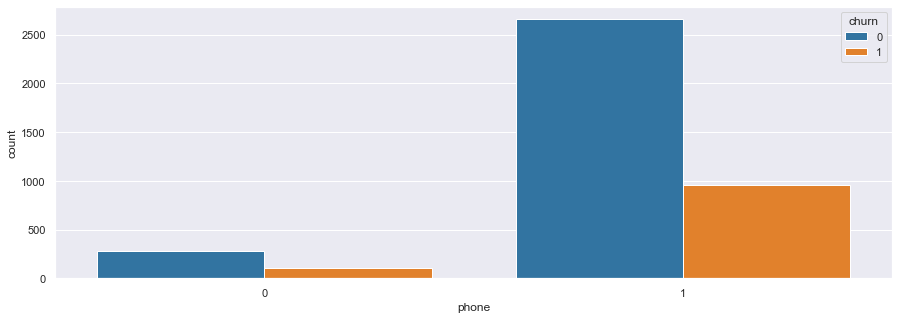

> Contract_period:


,count,mean,std,min,25%,50%,75%,max
churn,,,,,,,,
0,2939.0,5.747193,4.716942,1.0,1.0,6.0,12.0,12.0
1,1061.0,1.728558,2.132371,1.0,1.0,1.0,1.0,12.0


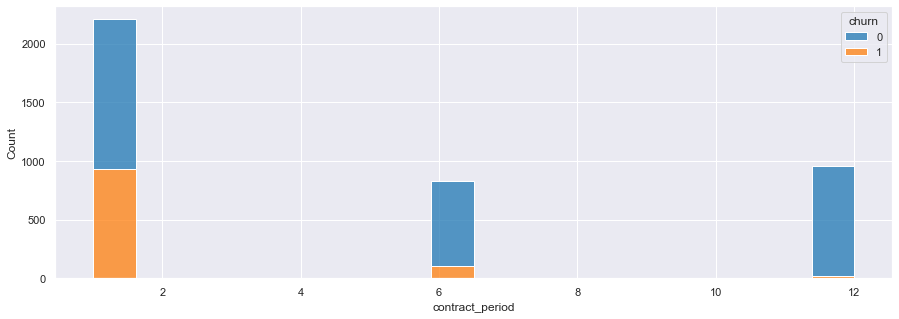

> Group_visits:


,count,mean,std,min,25%,50%,75%,max
churn,,,,,,,,
0,2939.0,0.464103,0.498795,0.0,0.0,0.0,1.0,1.0
1,1061.0,0.268615,0.443448,0.0,0.0,0.0,1.0,1.0


,0,1
group_visits,0,1
churn rate,33.0%,17.3%


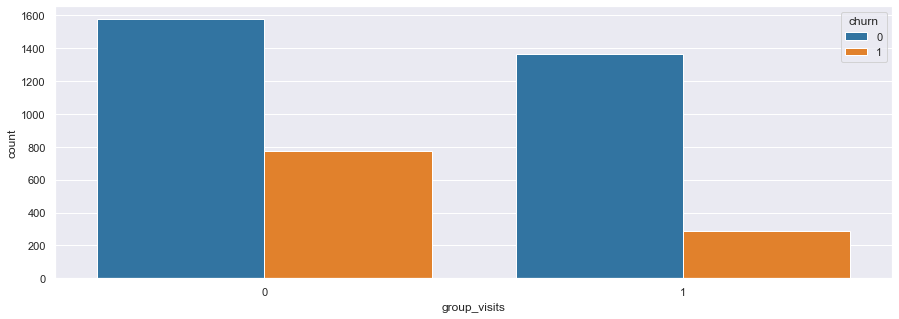

> Age:


,count,mean,std,min,25%,50%,75%,max
churn,,,,,,,,
0,2939.0,29.976523,3.009933,19.0,28.0,30.0,32.0,41.0
1,1061.0,26.989632,2.895163,18.0,25.0,27.0,29.0,38.0


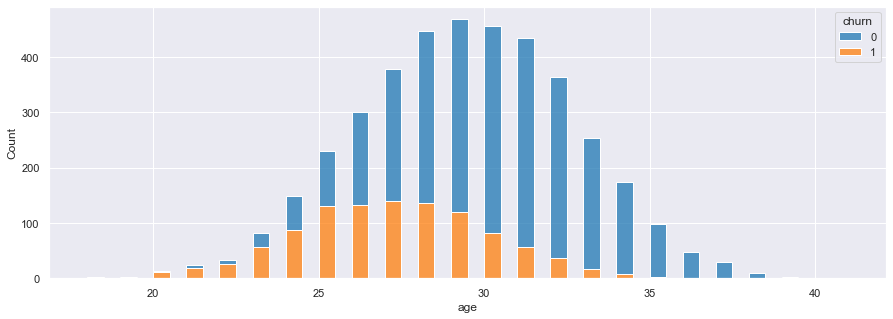

> Avg_additional_charges_total:


,count,mean,std,min,25%,50%,75%,max
churn,,,,,,,,
0,2939.0,158.445724,99.801582,0.171862,76.920994,149.881165,224.448273,552.590759
1,1061.0,115.082878,77.696396,0.148205,50.629128,103.814682,165.616852,425.535217


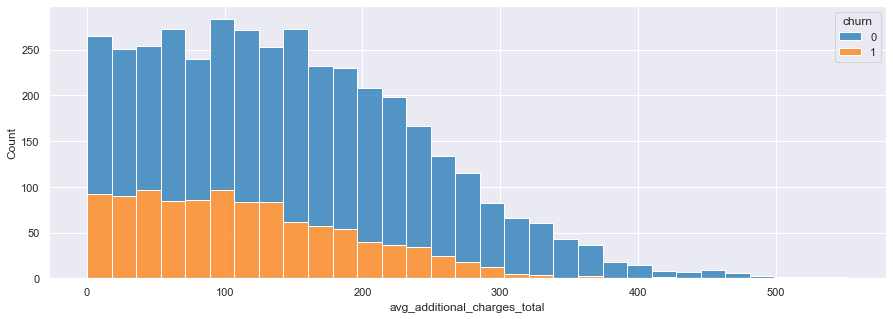

> Month_to_end_contract:


,count,mean,std,min,25%,50%,75%,max
churn,,,,,,,,
0,2939.0,5.283090,4.363534,1.0,1.0,6.0,10.0,12.0
1,1061.0,1.662583,1.964586,1.0,1.0,1.0,1.0,12.0


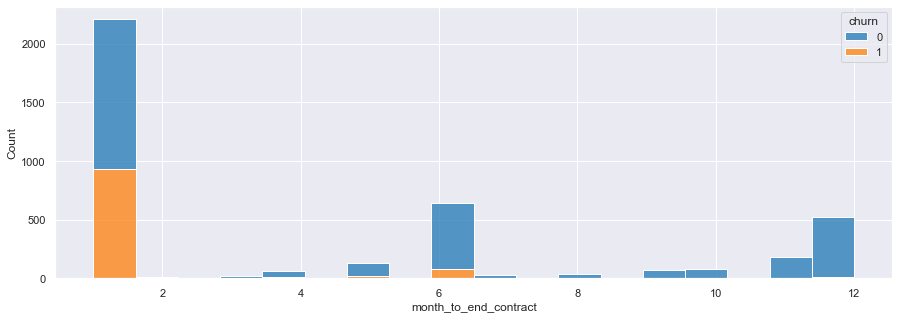

> Lifetime:


,count,mean,std,min,25%,50%,75%,max
churn,,,,,,,,
0,2939.0,4.711807,3.874780,0.0,2.0,4.0,6.0,31.0
1,1061.0,0.990575,1.110799,0.0,0.0,1.0,1.0,9.0


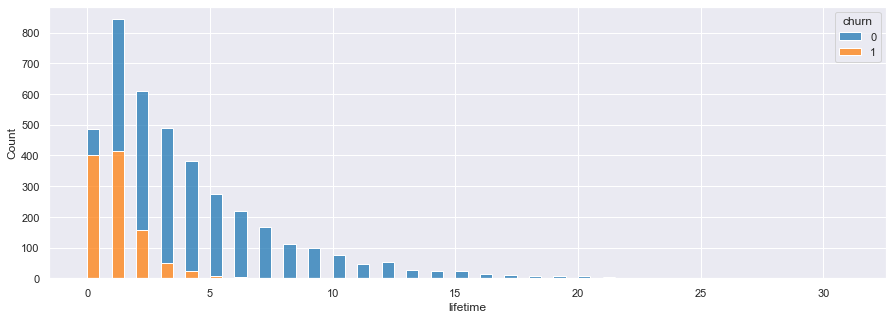

> Avg_class_frequency_total:


,count,mean,std,min,25%,50%,75%,max
churn,,,,,,,,
0,2939.0,2.024875,1.016007,0.0,1.283137,2.043252,2.732944,6.023668
1,1061.0,1.474995,0.694705,0.0,1.010771,1.491187,1.956438,3.478646


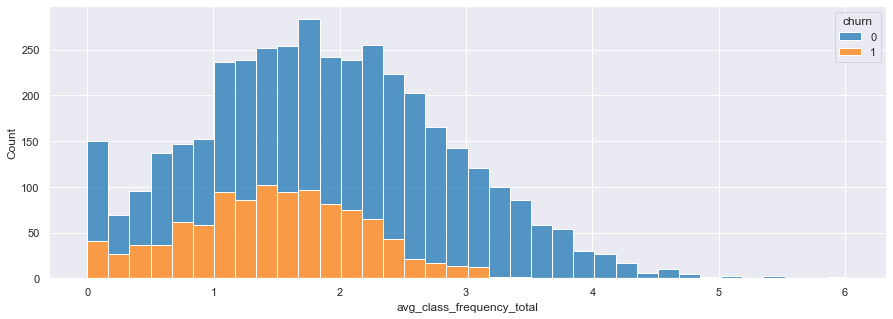

> Avg_class_frequency_current_month:


,count,mean,std,min,25%,50%,75%,max
churn,,,,,,,,
0,2939.0,2.027880,1.018994,0.0,1.297021,2.046697,2.740648,6.146783
1,1061.0,1.044546,0.770236,0.0,0.421337,0.979445,1.588576,3.540271


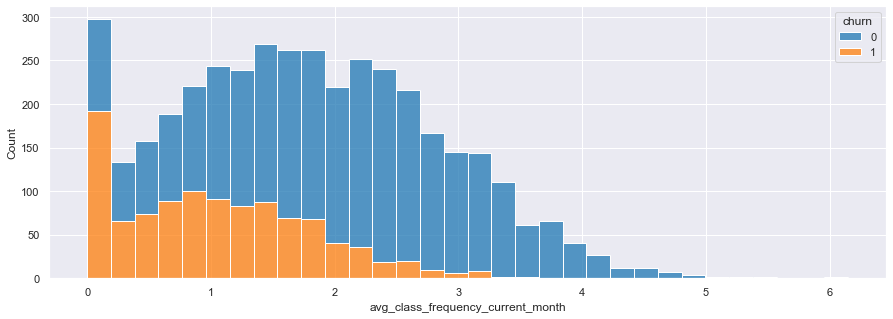

In [12]:
for i in df.drop('churn',axis=1).columns.to_list():
    print('>\033[1m {:}:\033[0m'.format(i.capitalize()))
    display(feature_desc[i])
    plt.figure(figsize=(15,5))
    if i in mul_col:
        sns.histplot(data=df, x=i, hue='churn',multiple="stack", palette='tab10')
    elif i in bin_col:
        display(df.groupby(i)['churn'].mean().sort_values(ascending=False).apply(lambda x: '{:.1%}'.format(x))
            .reset_index().rename(columns={'churn':'churn rate'}).T)
        sns.countplot(data=df, x=i, hue='churn', palette='tab10')
        plt.xticks((0,1))
    plt.show()

Lets summarize this mini-report:
1. Once again, it seems that when it comes to the clients who left, there is indifference about the client's **gender**.
1. The churn rate among costumers who **live or work nearby** is lower than among customers who don't.
1. Customers who work for **partner companies** tend to leave less than those who do not. Same thing for costumers who registered by **"Bring a Friend"** promotion.
1. Perhaps naturally, the churn rates decreases as the **registration period** lengthens, so that it has the highest among the customers who have registered for one month and the lowest among customers who have registered for a year.
1. The churn rate exists almost exclusively among customers who have one **month left** until the end of the period. It exists very marginally for the rest of the months.
1. The churn rates are also lower for those who attend **group classes**.
1. Chrun is less likely to occure as the **age** of the costumer gets higher.
1. The more months a client has been registered to the gym throughout his lifetime, the less likely he is to leave.
1. The **average frequency** of visits per week, both in current month and in total, shows a slight difference between the customers who leave and those who stay, much less than I expected. Maybe the difference between the averages will have more impact?

Before I answer my last question, I want to check the level of correlation between the features, both to get another picture of the effects on churn, and also to make sure that there is no high correlation between the other features that could harm the quality of the model, therfore the quality of my predictions.

### The story of the Correlation Matrix

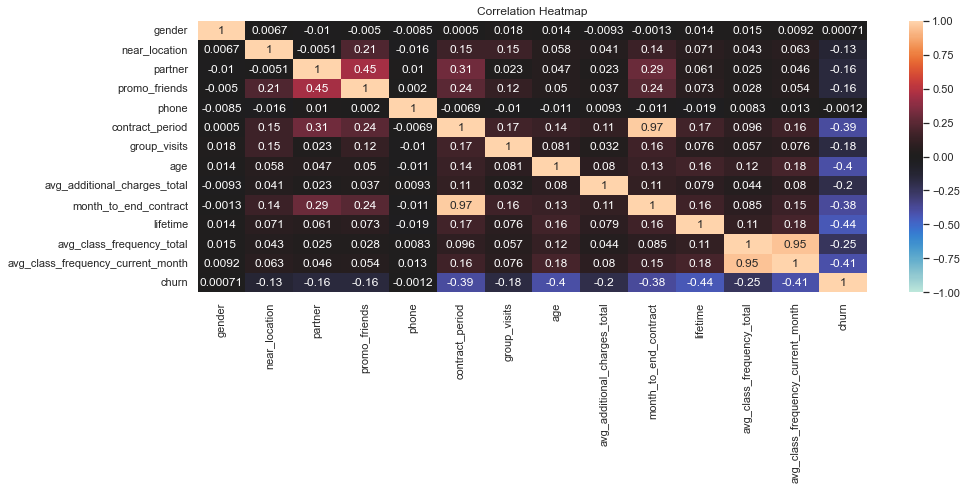

In [13]:
plt.figure(figsize=(15,5))
sns.heatmap(df.corr(),annot=True,cmap="icefire",vmin=-1,vmax=1)
plt.title('Correlation Heatmap')
plt.show()

The correlation matrix above shows the strength of the existing relationships between the variables and their direction (positive or negative). Of all the contexts presented in it, special importance should be attached to two specific types of contexts:

#### Avoiding multi-correlation

Before I examine the relationships between churn and other variables, it is necessary to address strong relationships between the variables and themselves in order to avoid multi-correlation.

One very strong positive relationship (correlation coefficient of 0.95) exists between `avg_class_frequency_total` to `avg_class_frequency_current_month`. In order to fix it, first I must take a closer look on this relationship, and the affect on churn:

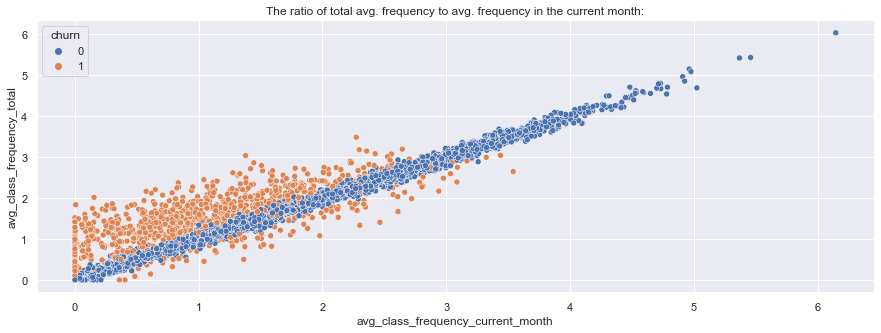

In [14]:
plt.figure(figsize=(15,5))
sns.scatterplot(x=df['avg_class_frequency_current_month'],y=df['avg_class_frequency_total'],hue=df['churn'])
plt.title('The ratio of total avg. frequency to avg. frequency in the current month:')
plt.show()

The chart above shows very clearly what is about the average frequency that affect the churn: costumers who tend to leave are **changing** their "consumption habits" in their last month at the gym. Therfore I will calculate a new column: `avg_class_frequency_gap` which will store in it the absolute difference (**the change**) between the average in total to the average of current month alone.

In [15]:
df['avg_class_frequency_gap'] = abs(df['avg_class_frequency_total'] - df['avg_class_frequency_current_month'])
df[['avg_class_frequency_total','avg_class_frequency_current_month','avg_class_frequency_gap','churn']].head()

,avg_class_frequency_total,avg_class_frequency_current_month,avg_class_frequency_gap,churn
0,0.020398,0.000000,0.020398,0
1,1.922936,1.910244,0.012693,0
2,1.859098,1.736502,0.122596,0
3,3.205633,3.357214,0.151582,0
4,1.113884,1.120078,0.006194,0


In [16]:
df.groupby('churn')['avg_class_frequency_gap'].agg(['mean','std'])

,mean,std
churn,,
0,0.079068,0.060834
1,0.523701,0.367125


It is important to take into account that there is great importance to the number of times a trainee arrives even regardless of the gap between the last month, so I will also keep the `avg_class_frequency_total` column so I will keep all the data that is important to predict without risking multi-correlation.

Another very strong connection can be found between the contract period to `month_to_end_contract`, possibly due to the large amount of clients who chose one month contract period, and most of them have one month left.

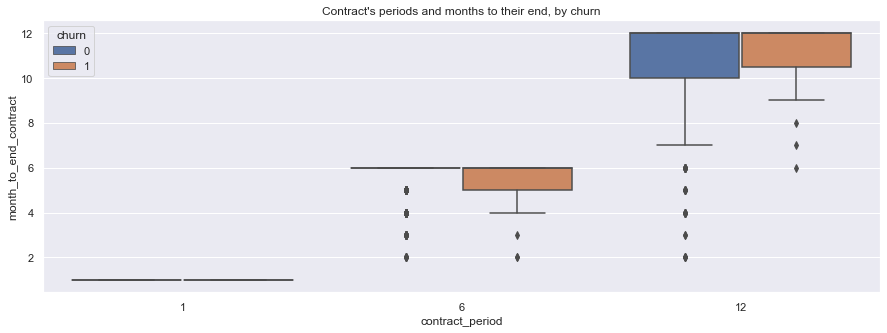

In [17]:
plt.figure(figsize=(15,5))
sns.boxplot(x=df['contract_period'], y=df['month_to_end_contract'], hue=df['churn'])
plt.title("Contract's periods and months to their end, by churn")
plt.show()

It seems like most customers do not leave at the end of the subscription, but at the beginning of the period. Call it "cold feet". But this time, even if I calculate the relative time left from the contract period, it will not help me to avoid multi-correlation with the contract period for the same reason that it exists now - everyone who chose one-month period (the majority) has one more month left.

Therefore, I choose to leave the feature `contract_period` only and remove `month_to_end_contract` completely.

### Final Features

It's time to create a new data frame containing only the selected features.

The following is a list of selected features:

In [18]:
mdf = df.drop(['gender','phone','month_to_end_contract','partner','promo_friends',
               'avg_class_frequency_current_month'],
              axis=1)
mdf.columns.tolist()

['near_location',
 'contract_period',
 'group_visits',
 'age',
 'avg_additional_charges_total',
 'lifetime',
 'avg_class_frequency_total',
 'churn',
 'avg_class_frequency_gap']

Now let's take a look at the matrix again, for the *Model Data Frame*:

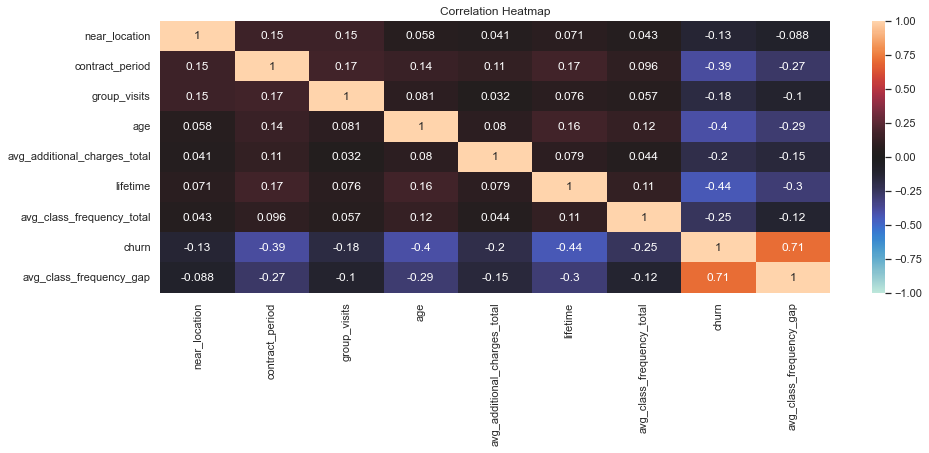

In [19]:
plt.figure(figsize=(15,5))
sns.heatmap(mdf.corr(),annot=True,cmap="icefire",vmin=-1,vmax=1)
plt.title('Correlation Heatmap')
plt.show()

#### Correlation in relation to churn

The table now contains shades of red and blue, indicating strong relationships between the variables, especially in the churn column and much less in the rest. This means we have managed to remove suspicion of multi-correlation, and more than that, we have stronger ties now for the `churn`.

---
## ML model to predict users churn

### Dividing the data into features and a target variable

In the first step I will define `churn` as a type Y variable and the rest as a type X variables, because I want my model to test how a change in the features (the X's) is likely to affect a specipic user churn.

I will then ask Python to randomly divide the data into control and test groups and adjust them so that they are identical in proportions.

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage 

In [21]:
X = mdf.drop('churn',axis=1)
y = mdf['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

### Training Models and Selecting the Best One 

To get the best forecast, I will build a function that goes over three models that can suit to my type of prections:
1. Random Forest
1. Logistic Regression
1. Gradient Boosting

The function will print every measure metrics and a confusion matrix.

In [22]:
models = [RandomForestClassifier(random_state=0),
          LogisticRegression(solver='liblinear', random_state = 0),
          GradientBoostingClassifier(random_state = 0)]

In [23]:
def print_all_metrics(y_true, y_pred, y_proba):
    print('\tAccuracy:          {:.2%}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision:         {:.2%}'.format(precision_score(y_true, y_pred)))
    print('\tRecall:            {:.2%}'.format(recall_score(y_true, y_pred)))
    print('\tF1:                {:.2%}'.format(f1_score(y_true, y_pred)))

In [43]:
def make_prediction(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]
    sns.heatmap(pd.DataFrame(confusion_matrix(y_test,y_pred)),annot=True,fmt=',d', cbar=False)
    plt.title('Confussion Matrix:')
    plt.ylabel('True')
    plt.xlabel('Prediction')
    plt.show()
    print_all_metrics(y_test, y_pred, y_prob)
    print('{:-<50}'.format(''))

RandomForestClassifier(random_state=0)


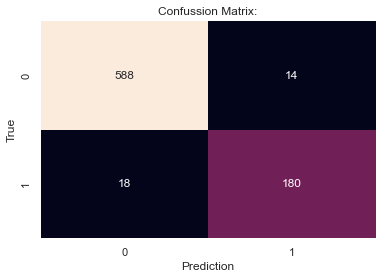

	Accuracy:          96.00%
	Precision:         92.78%
	Recall:            90.91%
	F1:                91.84%
--------------------------------------------------
LogisticRegression(random_state=0, solver='liblinear')


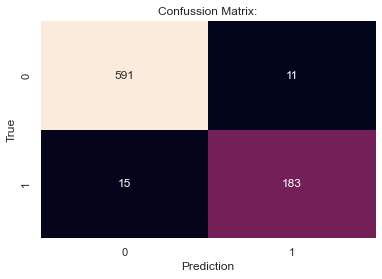

	Accuracy:          96.75%
	Precision:         94.33%
	Recall:            92.42%
	F1:                93.37%
--------------------------------------------------
GradientBoostingClassifier(random_state=0)


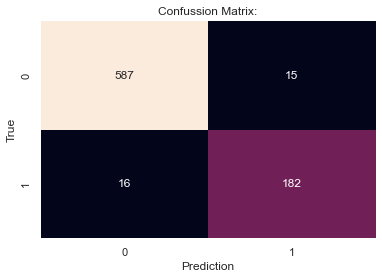

	Accuracy:          96.12%
	Precision:         92.39%
	Recall:            91.92%
	F1:                92.15%
--------------------------------------------------


In [44]:
for i in models:
    print(i)
    make_prediction(i, X_train, y_train, X_test, y_test)

I am choosing the model with the highest F1 score, a harmonizing metric that takes into account the balance between the metrics - ***Logistic Regression***.

1. **Accuracy** - % of right predictions : **96.8%** $(\frac{774}{800})$
1. **Precision** - % of true churn out of predicted churn : **94.3%** $(\frac{183}{194})$
1. **Recall** - % of predicted churn out of true churn : **92.4%** $(\frac{183}{198})$

The *logistic regression* algorithm is leading in all the metrics on the rest.

---
## User Clusters

### Agglomerative hierarchical clustering

In [26]:
scaler = StandardScaler()
x_sc = scaler.fit_transform(mdf.drop(columns ='churn'))

In [27]:
linked = linkage(x_sc, method = 'ward') 

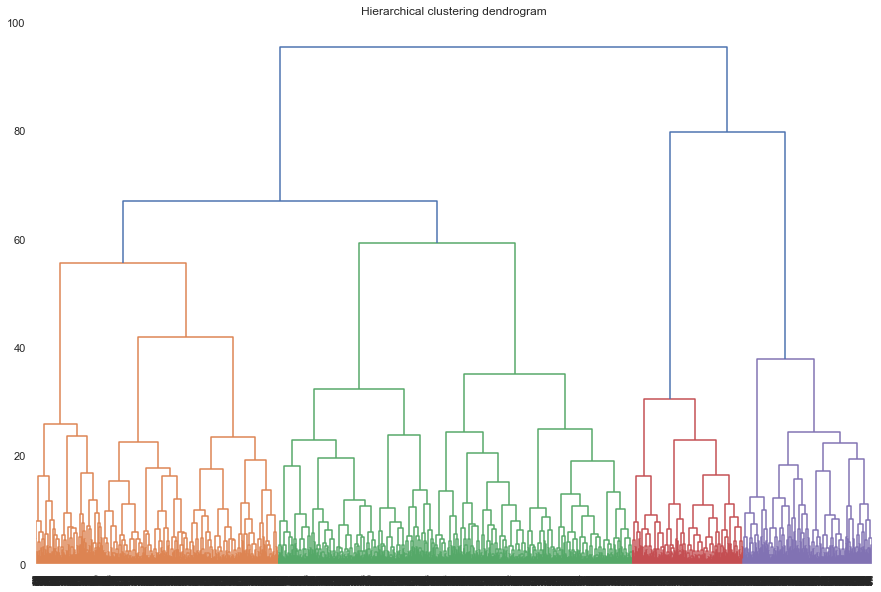

In [28]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top',show_leaf_counts=True)
plt.title('Hierarchical clustering dendrogram')
plt.show()

The graph above shows that the gym's clients can be divided into four clusters, hence four colors, but on closer inspection, when examining the distances between the intersections, the large distances show an almost forced connection between the clusters. Therfore I will add one more cluster when I check out the K-MEANS.

### K-means
Now let's run the K-means algorithm, when the number of clusters is five, then I will group the costumers by their cluster and inspect the mean of each feature for each cluster.

In [29]:
km = KMeans(n_clusters = 5, random_state=0)
labels = km.fit_predict(x_sc)
mdf['cluster'] = labels

cluster_means = mdf.groupby('cluster').mean()
cluster_means

,near_location,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_total,churn,avg_class_frequency_gap
cluster,,,,,,,,,
0,0.996629,12.000000,0.559551,29.876404,164.408340,4.712360,2.017767,0.013483,0.083326
1,0.899807,1.730250,0.281310,26.400771,106.794952,1.017341,1.551058,1.000000,0.792480
2,0.000000,3.173759,0.237589,28.966312,141.441147,3.239362,1.787574,0.343972,0.179002
3,1.000000,2.836969,1.000000,29.888634,150.885864,4.235362,1.979064,0.112514,0.096690
4,1.000000,2.496540,0.000000,29.476644,151.237457,4.032007,1.888677,0.205882,0.101553


I can already detect some differences in the clusters means, but in order to get the full picture I will present them like this:

> Near_location:


,0,1,2,3,4
Cluster,0.000000,1.000000,2.0,3.0,4.0
Mean,0.996629,0.899807,0.0,1.0,1.0


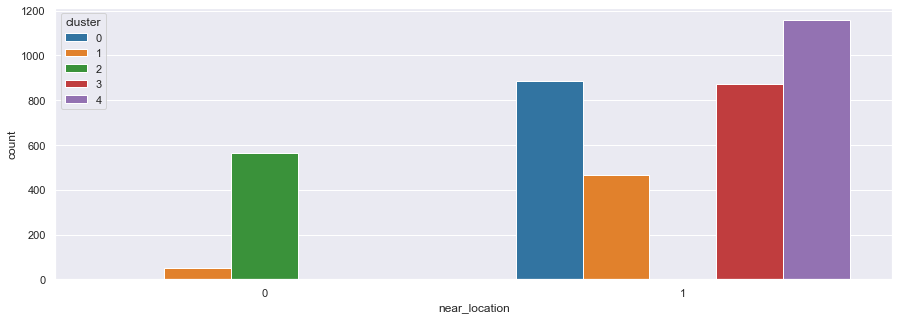

> Contract_period:


,0,1,2,3,4
Cluster,0.0,1.00000,2.000000,3.000000,4.00000
Mean,12.0,1.73025,3.173759,2.836969,2.49654


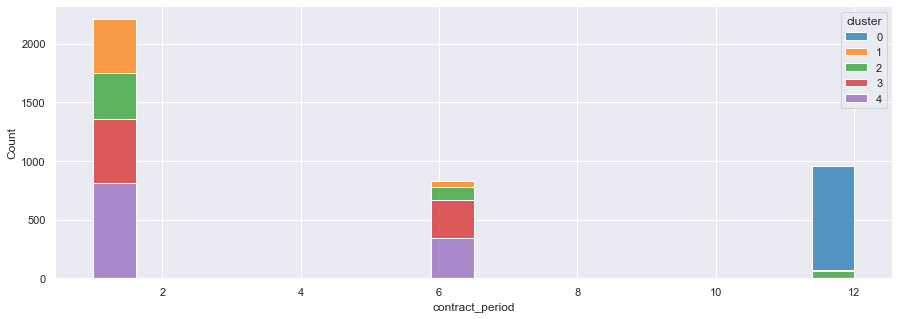

> Group_visits:


,0,1,2,3,4
Cluster,0.000000,1.00000,2.000000,3.0,4.0
Mean,0.559551,0.28131,0.237589,1.0,0.0


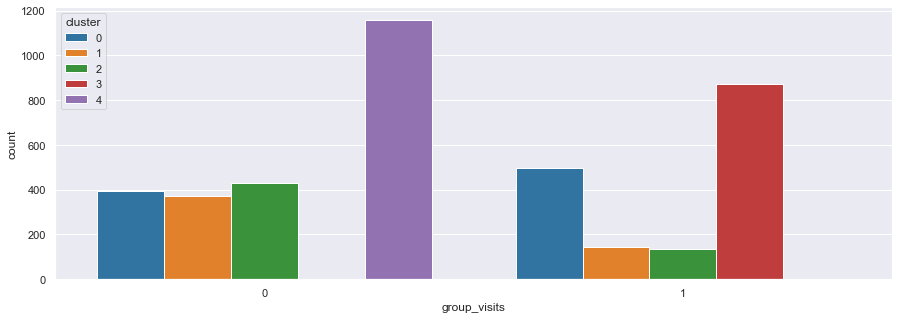

> Age:


,0,1,2,3,4
Cluster,0.000000,1.000000,2.000000,3.000000,4.000000
Mean,29.876404,26.400771,28.966312,29.888634,29.476644


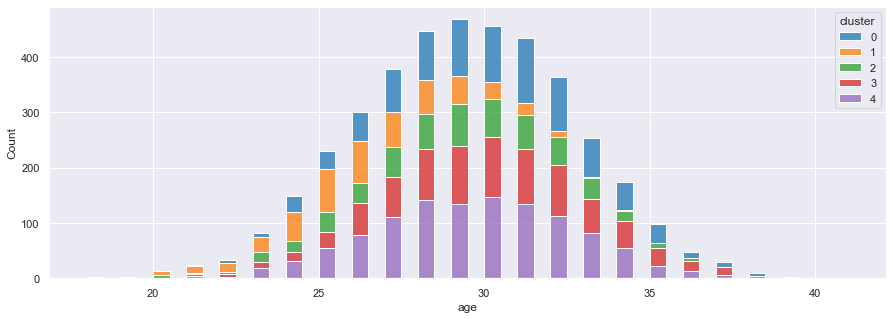

> Avg_additional_charges_total:


,0,1,2,3,4
Cluster,0.00000,1.000000,2.000000,3.000000,4.000000
Mean,164.40834,106.794952,141.441147,150.885864,151.237457


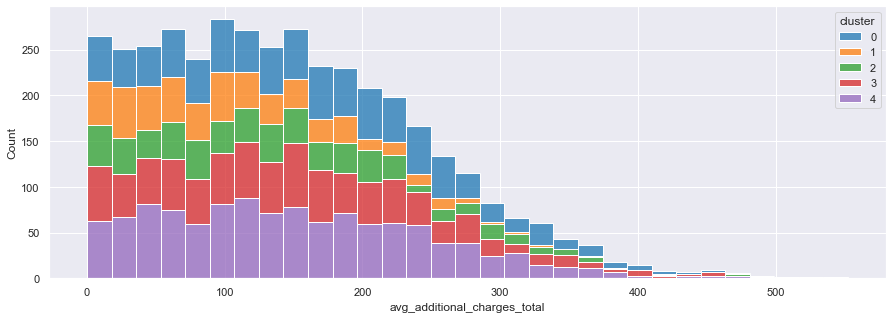

> Lifetime:


,0,1,2,3,4
Cluster,0.00000,1.000000,2.000000,3.000000,4.000000
Mean,4.71236,1.017341,3.239362,4.235362,4.032007


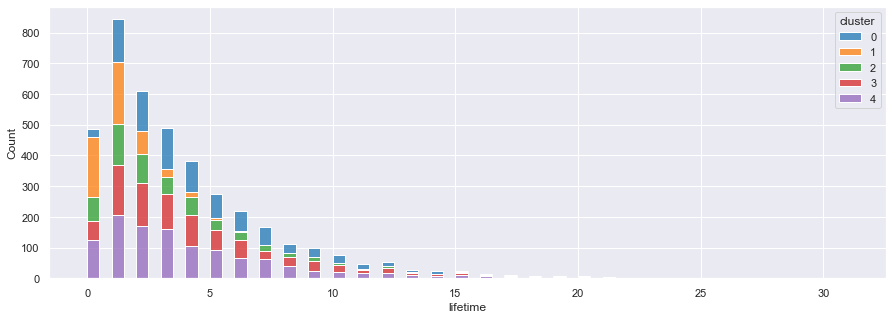

> Avg_class_frequency_total:


,0,1,2,3,4
Cluster,0.000000,1.000000,2.000000,3.000000,4.000000
Mean,2.017767,1.551058,1.787574,1.979064,1.888677


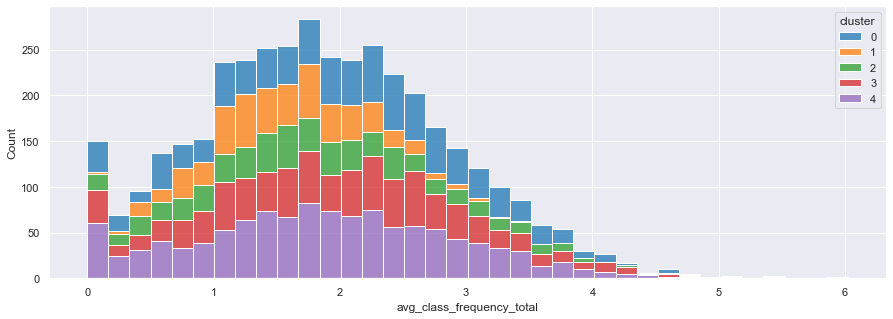

> Churn:


,0,1,2,3,4
Cluster,0.000000,1.0,2.000000,3.000000,4.000000
Mean,0.013483,1.0,0.343972,0.112514,0.205882


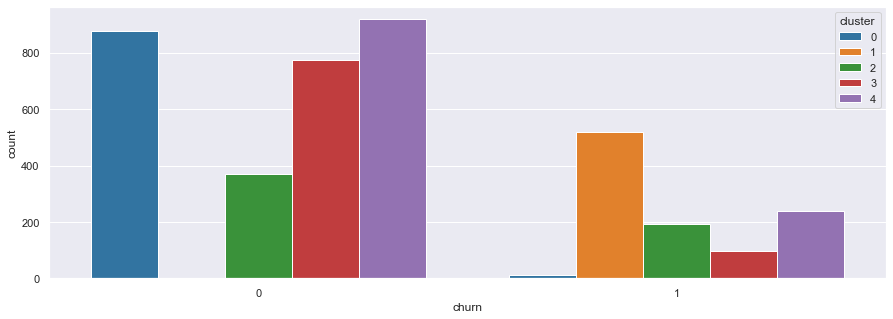

> Avg_class_frequency_gap:


,0,1,2,3,4
Cluster,0.000000,1.00000,2.000000,3.00000,4.000000
Mean,0.083326,0.79248,0.179002,0.09669,0.101553


<Figure size 1080x360 with 0 Axes>

In [30]:
for i in mdf.drop('cluster',axis=1).columns.to_list():
    print('>\033[1m {:}:\033[0m'.format(i.capitalize()))
    plt.figure(figsize=(15,5))
    display(cluster_means[i].reset_index().rename(columns={'cluster':'Cluster',i:'Mean'}).T)
    if i in mul_col:
        sns.histplot(data=mdf, x=i, hue='cluster',multiple="stack", palette='tab10')
    if i in bin_col or i=='churn':
        sns.countplot(data=mdf, x=i, hue='cluster', palette='tab10')
        plt.xticks((0,1))
    plt.show()

Before I am drawing mu conclusions, let's give our clustering a score. a **silhouette score**.

In [31]:
from sklearn.metrics import silhouette_score

print('Silhouette score: {:.2f}'.format(silhouette_score(x_sc, labels)))

Silhouette score: 0.18


We got a score of 0.18. It is far from -1 which means it is not bad, but it also too far from 1 to be considered as good.

**Clustering Summary:**
The segmantation of the clients and their division into cluster was not really successful, but given the homogeneity of the gym's clients (they are all fitness enthusiasts and have a lot in common thanks to this connection) I have to consider what differentiates them nonetheless:
* Cluster 0: **Long-runners**. They sign up for 12 months periods, they come to the gym more often and spend more on average on other gym services.
* Cluster 1: **Indecisives**. They are relativly younger and most of them are new costumers, they sign for short periods and they have large gaps in the average number of weekly workouts.
* Cluster 2: **Those who come from afar**.
* Cluster 3: **Team-workers**. They tend to join more than the rest to group classes.
* Cluster 4: **Loners**. They tend not to join to group classes at all.

As I mentioned earlier, the best metric the data offers us for customer churn is the interval between the overall weekly training average and that of the last month. So it's not surprising that Cluster 1, the Indecisives, is the only one with 100% churn rate.

---
## Overall Conclusions

After an in-depth analysis of the data I found that it is possible to differentiate between the clients of our gym mainly by changes in the average number of their weekly workouts: Those who are consistent tend to leave less than those who fundamentally change the number of workouts.

With the help of this interval calculation and the addition of additional key metrics, I was able to produce a very good forecast model to predict churn for any costumer. I have chose the algorithm that displayed the best results: Logistic Regression. It provides preditions with accuracy of 96.8%.

As for costumer clustering, althogh our clients are pretty much homogeneous, I have manage to divide them into 5 clusters. Unsurprisingly, the cluster in which everyone leaves the gym has been named as "the indecisive".

### Recommendations

Given the conclusions above, the gym chain must put some extra efforts in order to convert "indecisives" into "long-runners". We should concider some kind of incentive for long time period contracts and also for group classes. We need to think of as many ways as possible to deepen the clients involvement in the gym's activities - an involved client is a loyal client.